In [5]:
!pip install opencv-python-headless numpy pandas seaborn matplotlib tensorflow h5py pillow scikit-image scikit-learn mlxtend


  Using cached scikit_image-0.25.2-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.4 MB ? eta -:--:--
    --------------------------------------- 0.5/39.4 MB 645.7 kB/s eta 0:01:01
    --------------------------------------- 0.5/39.4 MB 645.7 kB/s eta 0:01:01
    --------------------------------------- 0.8/39.4 MB 657.8 kB/s eta 0:00:59
   - -------------------------------------- 1.0/39.4 MB 786.4 kB/s eta 0:00:49
   - -------------------------------------- 1.0/39.4 MB 786.4 kB/s eta 0:00:49
   - -------------------------------------- 1.3/39.4 MB 789.6 kB/s eta 0:00:49
   - --------------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sanga\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil
import cv2
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,
    SeparableConv2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Optional: Only for Jupyter notebooks
# %matplotlib inline

# Set seeds for reproducibility
seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

# Set seaborn color palette
color = sns.color_palette()


In [9]:
import os

# Use raw string for Windows path
root = r"C:\Users\sanga\Downloads\archive"
input_dir = os.path.join(root, "LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")


Main directories	: ['LCC_FASD']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [10]:

# Extract label names from training set
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

# Initialize directories for train, val, test
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length = {}, {}, {}

# Collect image counts and sample images
for key, dir_path in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0

    for label in label_name:
        label_path = os.path.join(dir_path, label)
        label_list = sorted(glob.glob(os.path.join(label_path, "*.png")))

        if len(label_list) == 0:
            continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)

        select_img_id = np.random.randint(len(label_list))
        img_disp[key][label] = label_list[select_img_id]

    set_length[key] = set_count

# Convert results to a DataFrame and display
case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)

print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1223   405   314
spoof   7076  2543  7266


In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [12]:
train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 8299 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [13]:
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


In [14]:
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')

freeze_before = None  
if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 23s 2us/step


In [15]:
x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)
# x = Dense(units=128, activation='relu', name='extra_fc1')(x)
# x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
print(model.summary())

Model: "mobilenetv2_spoof"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,626,689 (10.02 MB)

 Trainable params: 2,592,577 (9.89 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [34]:
train_id = "lcc-train04b-weight_all"  
num_epochs = 15  
learning_rate = 5e-5  

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Save entire model every epoch
cont_filepath = "mobilenetv2-epoch_{epoch:02d}.keras"
cont_checkpoint = ModelCheckpoint(
    os.path.join(save_dir, cont_filepath),
    save_weights_only=False
)

# Save best model weights only
best_filepath = "mobilenetv2-best.weights.h5"
best_checkpoint = ModelCheckpoint(
    os.path.join(save_dir, best_filepath),
    save_best_only=True,
    save_weights_only=True
)

# TensorBoard logging
log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

# Learning rate scheduler
plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta=0.005, min_lr=5e-7)

# Compute class weights
train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")


Training config of 'lcc-train04b-weight_all'...
Number of epoch	: 15
Initial LR	: 5e-05
Class weight	: {0: np.float64(3.392886345053148), 1: np.float64(0.5864188807235726)}


In [35]:
history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [best_checkpoint,
                                 cont_checkpoint,
                                 plateau_scheduler],
                    class_weight=class_weight)

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 984s 4s/step - acc: 0.8221 - loss: 0.3521 - val_acc: 0.8438 - val_loss: 0.7667 - learning_rate: 5.0000e-05
Epoch 2/15
  1/259 ━━━━━━━━━━━━━━━━━━━━ 16:35 4s/step - acc: 0.9688 - loss: 0.1248

c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.9688 - loss: 0.1248 - val_acc: 0.9688 - val_loss: 0.0615 - learning_rate: 5.0000e-05
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - acc: 0.9722 - loss: 0.0700 - val_acc: 0.8438 - val_loss: 0.4370 - learning_rate: 5.0000e-05
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.9688 - loss: 0.0237 - val_acc: 0.7812 - val_loss: 0.4819 - learning_rate: 5.0000e-05
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9808 - loss: 0.0474
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
259/259 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - acc: 0.9808 - loss: 0.0474 - val_acc: 0.8125 - val_loss: 0.3482 - learning_rate: 5.0000e-05
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 1.0000 - loss: 0.0057 - val_acc: 0.8750 - val_loss: 0.3853 - learning_rate: 1.0000e-05
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 856s 3s/step - acc: 0.9918 - loss: 0.0297 - val_acc: 0.9062 - val_loss: 0.5653 - learning_rat

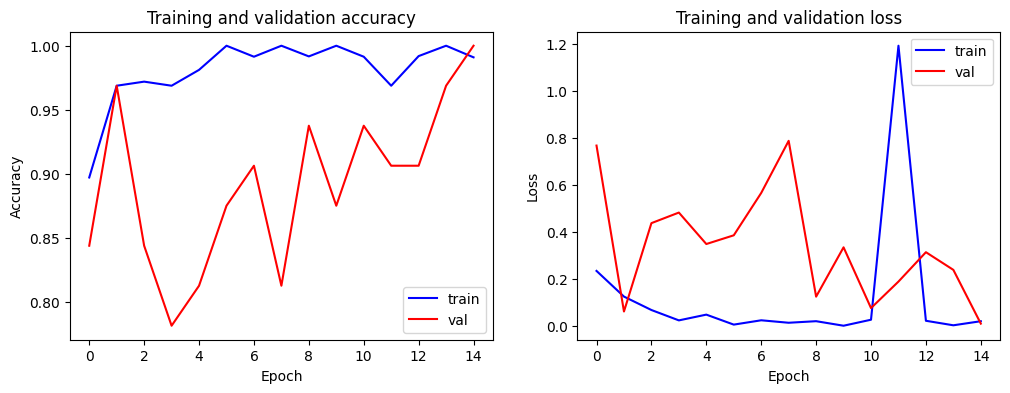

In [37]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))


plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')


plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [38]:
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

threshold = 0.5  
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes

7580/7580 ━━━━━━━━━━━━━━━━━━━━ 210s 28ms/step - acc: 0.9327 - loss: 0.2193
Test results Accuracy: 93.96% and Loss: 93.96
7580/7580 ━━━━━━━━━━━━━━━━━━━━ 175s 23ms/step


In [39]:
print(f"Label\t\t: {y_true[:50]}")
print(f"Prediction\t: {y_pred[:50]}")

Label		: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prediction	: [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0]


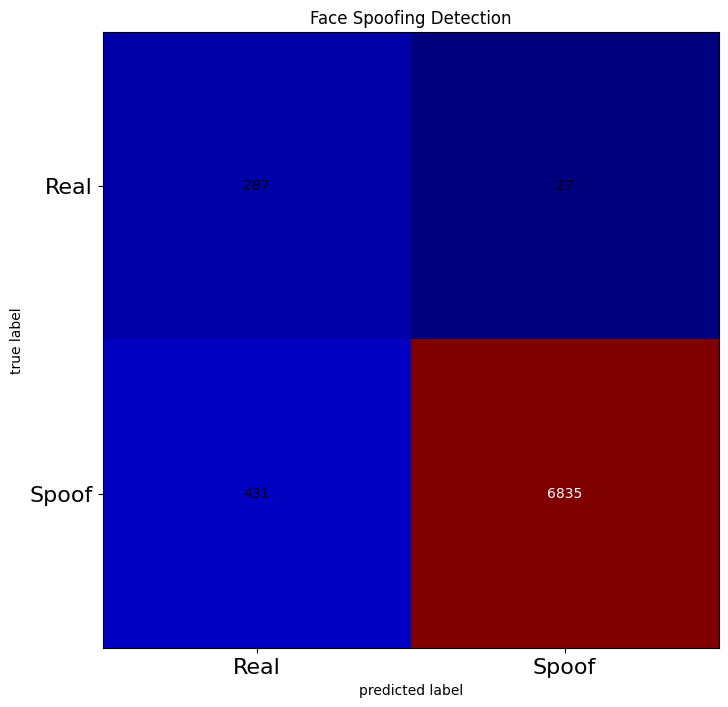

Report Summary:
Precision	: 99.61%
Recall		: 94.07%
F1 Score	: 96.76%

Notes: 
True labels	: Spoof
False labels	: Real


In [48]:
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()


tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")

In [41]:
model.save("face_antispoofing_model.h5")

In [51]:
model_path = r"C:\Users\sanga\Downloads\archive\LCC_FASD\some_model.keras"
model.save(model_path)
print("Model saved at:", model_path)


Model saved at: C:\Users\sanga\Downloads\archive\LCC_FASD\some_model.keras


In [53]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\sanga\Downloads\archive\LCC_FASD\some_model.keras"
model = load_model(model_path)


c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 162 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.9999529]


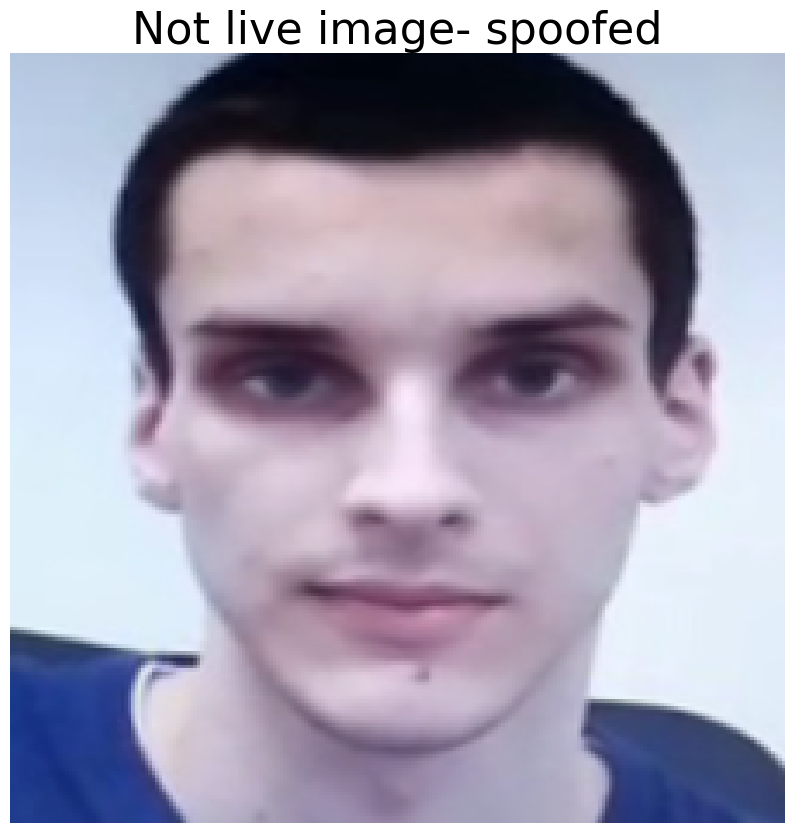

In [54]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = r"C:\Users\sanga\OneDrive\Desktop\output_dataset\spoof\FT720P_G780_REDMI4X_id1_s0_45.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

image_path = r"C:\Users\sanga\OneDrive\Desktop\output_dataset\spoof\FT720P_G780_REDMI4X_id1_s0_45.png"
img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
[0.00022468]


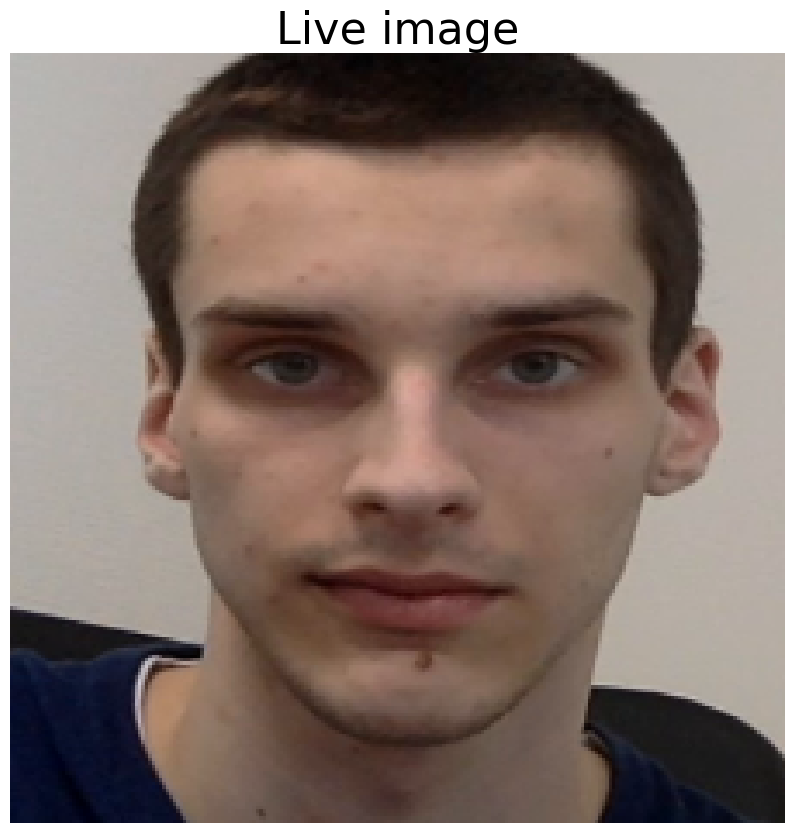

In [58]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = r"C:\Users\sanga\OneDrive\Desktop\output_dataset\real\FT720P_id1_s0_120.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

In [74]:
pip list

Package                   Version
------------------------- -----------
absl-py                   2.2.2
annotated-types           0.7.0
anyio                     4.4.0
asgiref                   3.8.1
asttokens                 3.0.0
astunparse                1.6.3
attrs                     24.3.0
blinker                   1.9.0
certifi                   2024.2.2
charset-normalizer        3.3.2
click                     8.1.7
clickclick                20.10.2
colorama                  0.4.6
comm                      0.2.2
connexion                 2.14.2
contourpy                 1.3.2
cowsay                    6.1
cycler                    0.12.1
debugpy                   1.8.14
decorator                 5.2.1
distlib                   0.3.8
distro                    1.9.0
Django                    5.1.2
django-cors-headers       4.7.0
django-crispy-forms       2.3
django-environ            0.11.2
django-widget-tweaks      1.5.0
djangorestframework       3.16.0
executing                

In [4]:
pip show keras

Name: keras
Version: 3.9.2
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow
Note: you may need to restart the kernel to use updated packages.
